In [ ]:
# default_exp tabular_models

In [ ]:
%load_ext autoreload
%autoreload 2

# Tabular models for enveco data

Use TabularPandas

In [ ]:
#export
from fastai.tabular.all import *
from fastai.data.all import *
from enveco.las import *
from enveco.image import *

In [ ]:
#export

def get_lidar_procs(row, path, mask_plot=True):
    "Function for LiDAR opening and processing steps"
    las_data = las_to_df(f'{path}/{row.sampleplotid}.las')
    if mask_plot == True: las_data = mask_plot_from_lidar(las_data, row.x, row.y)
    metrics = calc_lidar_metrics(las_data)
    return metrics

In [ ]:
#export

def get_image_procs(row, path, mask_plot=True):
    "Function for tif opening and processing steps"
    image_data = open_geotiff(f'{path}/{row.sampleplotid}.tif')
    if mask_plot == True: image_data = mask_plot_from_image(image_data, radius=31)
    metrics = calc_image_metrics(image_data)
    return metrics

In [ ]:
import pandas as pd
import re

df = pd.read_csv('../../enveco_data/enveco/AV.leaf.on.csv')
df = df.rename(columns = lambda x: re.sub('[\.]+', '_', x))
df.columns

Index(['sampleplotid', 'x', 'y', 'measurementdate', 'g', 'd', 'h', 'v', 'v_ma',
       'v_ku', 'v_lp', 'myear', 'filename_1', 'a_date_1', 'a_window_1',
       'filename_2', 'a_date_2', 'a_window_2'],
      dtype='object')

In [ ]:
df[get_las_metric_cols()] = df.apply(lambda row: get_lidar_procs(row, path='../../enveco_data/enveco/AV_las/', mask_plot=True), axis=1,
                                                 result_type='expand')

In [ ]:
df[get_image_metric_cols()] = df.apply(lambda row: get_image_procs(row, path='../../enveco_data/enveco/AV_tif/', mask_plot=True), axis=1,
                                                 result_type='expand')

<AxesSubplot:>

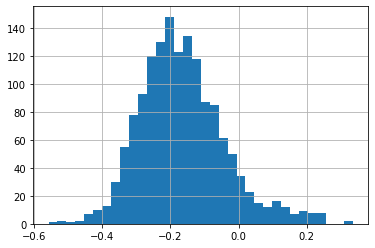

In [ ]:
df.ndvi_mean.hist(bins='auto')

In [ ]:
splits = RandomSplitter(valid_pct=0.2)(range_of(df))

In [ ]:
to = TabularPandas(df, procs=['Normalize'],
                   cont_names=get_las_metric_cols(), y_names=['g'],
                   splits=splits)

In [ ]:
dls = to.dataloaders(bs=64)

In [ ]:
from fastai.callback.mixup import *
mixup = MixUp(0.5)

In [ ]:
learn = tabular_learner(dls, metrics=[rmse, mae], callbacks=mixup)
learn.summary()

TabularModel (Input shape: ['64 x 0', '64 x 33'])
Layer (type)         Output Shape         Param #    Trainable 
BatchNorm1d          64 x 33              66         True      
________________________________________________________________
BatchNorm1d          64 x 33              66         True      
________________________________________________________________
Linear               64 x 200             6,600      True      
________________________________________________________________
ReLU                 64 x 100             0          False     
________________________________________________________________
BatchNorm1d          64 x 200             400        True      
________________________________________________________________
Linear               64 x 100             20,000     True      
________________________________________________________________
ReLU                 64 x 100             0          False     
________________________________________________

In [ ]:
learn.fit_one_cycle(50)

epoch,train_loss,valid_loss,_rmse,mae,time
0,441.826050,428.917480,20.710323,19.115854,00:00
1,437.174744,421.981812,20.542194,18.966660,00:00
2,428.906952,406.917877,20.172205,18.648882,00:00
3,418.686676,382.127960,19.548096,18.105986,00:00
4,400.941498,332.061707,18.222559,16.919434,00:00
5,369.040436,244.713791,15.643332,14.408136,00:00
6,318.294647,154.234604,12.419123,10.798675,00:00
7,257.055450,89.067772,9.437572,7.919921,00:00
8,196.710678,43.326771,6.582307,5.314987,00:00
9,147.243011,27.951687,5.286935,4.235329,00:00


In [ ]:
preds,y = learn.get_preds()

In [ ]:
learn.validate()

(#3) [14.958037376403809,3.8675622940063477,2.9612691402435303]

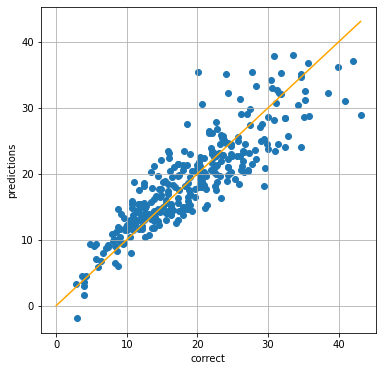

In [ ]:
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(6,6))
plt.scatter(y, preds)
plt.xlabel('correct')
plt.ylabel('predictions')
x = np.linspace(0, max(preds.max(),y.max()))
plt.plot(x, x, color='orange')
plt.grid()

In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
rf = RandomForestRegressor(n_estimators=500, max_features='log2')

In [ ]:
rf.fit(to.train.xs, to.train.ys.values.ravel())

RandomForestRegressor(max_features='log2', n_estimators=500)

In [ ]:
rf_preds = rf.predict(to.valid.xs)

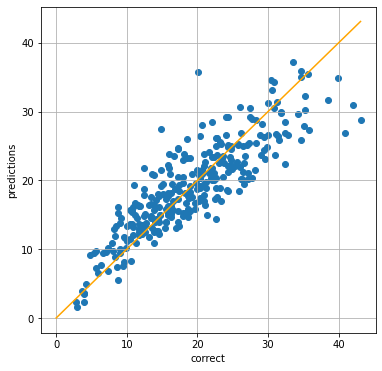

In [ ]:
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(6,6))
plt.scatter(to.valid.ys.values.ravel(), rf_preds)
plt.xlabel('correct')
plt.ylabel('predictions')
x = np.linspace(0, max(rf_preds.max(),y.max()))
plt.plot(x, x, color='orange')
plt.grid()

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
mean_squared_error(to.valid.ys.values.ravel(), rf_preds, squared=False), mean_absolute_error(to.valid.ys.values.ravel(), rf_preds)

(4.033682757670845, 3.0880443162710076)